# Photos to Anime with PaddleGAN and OpenVINO

This tutorial demonstrates converting a [PaddlePaddle/PaddleGAN](https://github.com/PaddlePaddle/PaddleGAN) AnimeGAN model to OpenVINO IR format, and shows inference results on the PaddleGAN and OpenVINO IR models.

For more information about the model, see [PaddleGAN's AnimeGAN documentation](https://github.com/PaddlePaddle/PaddleGAN/blob/develop/docs/en_US/tutorials/animegan.md)

![anime](https://user-images.githubusercontent.com/15709723/123559130-04550100-d74f-11eb-819c-a02284654428.jpg)


#### Table of contents:

- [Preparation](#Preparation)
    - [Install requirements](#Install-requirements)
    - [Imports](#Imports)
    - [Settings](#Settings)
    - [Functions](#Functions)
- [Inference on PaddleGAN Model](#Inference-on-PaddleGAN-Model)
    - [Show Inference Results on PaddleGAN model](#Show-Inference-Results-on-PaddleGAN-model)
- [Model Conversion to ONNX and OpenVINO IR](#Model-Conversion-to-ONNX-and-OpenVINO-IR)
    - [Convert to ONNX](#Convert-to-ONNX)
    - [Convert to OpenVINO IR](#Convert-to-OpenVINO-IR)
- [Show Inference Results on OpenVINO IR and PaddleGAN Models](#Show-Inference-Results-on-OpenVINO-IR-and-PaddleGAN-Models)
    - [Create Postprocessing Functions](#Create-Postprocessing-Functions)
    - [Do Inference on OpenVINO IR Model](#Do-Inference-on-OpenVINO-IR-Model)
        - [Select inference device](#Select-inference-device)
- [Performance Comparison](#Performance-Comparison)
- [References](#References)



## Preparation
[back to top ⬆️](#Table-of-contents:)

### Install requirements
[back to top ⬆️](#Table-of-contents:)


In [31]:
import platform

%pip install -q "openvino>=2023.1.0"

%pip install -q "paddlepaddle>=2.5.1" "paddle2onnx>=0.6"
%pip install -q "git+https://github.com/PaddlePaddle/PaddleGAN.git" --no-deps

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

%pip install -q opencv-python scikit-learn "scikit-image>=0.20.0"
%pip install -q "imageio==2.9.0" "imageio-ffmpeg" "numba>=0.53.1" easydict munch natsort

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Imports
[back to top ⬆️](#Table-of-contents:)


In [32]:
import sys
import time
import os
from pathlib import Path
import requests

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
from IPython.display import HTML, display

# PaddlePaddle requires a C++ compiler. If importing the paddle packages fails,
# install C++.
try:
    import paddle
    from paddle.static import InputSpec
    from ppgan.apps import AnimeGANPredictor
except NameError:
    if sys.platform == "win32":
        install_message = (
            "To use this notebook, please install the free Microsoft "
            "Visual C++ redistributable from <a href='https://aka.ms/vs/16/release/vc_redist.x64.exe'>"
            "https://aka.ms/vs/16/release/vc_redist.x64.exe</a>"
        )
    else:
        install_message = (
            "To use this notebook, please install a C++ compiler. On macOS, "
            "`xcode-select --install` installs many developer tools, including C++. On Linux, "
            "install gcc with your distribution's package manager."
        )
    display(
        HTML(
            f"""<div class="alert alert-danger" ><i>
    <b>Error: </b>PaddlePaddle requires installation of C++. {install_message}"""
        )
    )
    raise

### Settings
[back to top ⬆️](#Table-of-contents:)


In [33]:
MODEL_DIR = "model"
MODEL_NAME = "paddlegan_anime"

os.makedirs(MODEL_DIR, exist_ok=True)

# Create filenames of the models that will be converted in this notebook.
model_path = Path(f"{MODEL_DIR}/{MODEL_NAME}")
ir_path = model_path.with_suffix(".xml")
onnx_path = model_path.with_suffix(".onnx")

### Functions
[back to top ⬆️](#Table-of-contents:)


In [34]:
def resize_to_max_width(image, max_width):
    """
    Resize `image` to `max_width`, preserving the aspect ratio of the image.
    """
    if image.shape[1] > max_width:
        hw_ratio = image.shape[0] / image.shape[1]
        new_height = int(max_width * hw_ratio)
        image = cv2.resize(image, (max_width, new_height))
    return image

## Inference on PaddleGAN Model
[back to top ⬆️](#Table-of-contents:)

The PaddleGAN [documentation](https://github.com/PaddlePaddle/PaddleGAN/blob/develop/docs/en_US/tutorials/animegan.md) explains how to run the model with `.run()` method. Find out what that function does with Jupyter's `??` shortcut to show the docstring and source of the function.

In [35]:
# This cell will initialize the AnimeGANPredictor() and download the weights from PaddlePaddle.
# This may take a while. The weights are stored in a cache and are downloaded once.
predictor = AnimeGANPredictor()

[06/05 13:20:52] ppgan INFO: Found /home/ubuntu/.cache/ppgan/animeganv2_hayao.pdparams


In [36]:
# In a Jupyter Notebook, ?? shows the source and docstring
??predictor.run

Signature: predictor.run(image)
Docstring: <no docstring>
Source:   
    def run(self, image):
        image = cv2.cvtColor(cv2.imread(image, flags=cv2.IMREAD_COLOR),
                             cv2.COLOR_BGR2RGB)
        transformed_image = self.transform(image)
        anime = (self.generator(paddle.to_tensor(transformed_image[None, ...]))
                 * 0.5 + 0.5)[0].numpy() * 255
        anime = anime.transpose((1, 2, 0))
        if anime.shape[:2] != image.shape[:2]:
            # to original size
            anime = T.resize(anime, image.shape[:2])
        if self.use_adjust_brightness:
            anime = self.adjust_brightness(anime, image)
        else:
            anime = anime.astype('uint8')
        if not os.path.exists(self.output_path):
            os.makedirs(self.output_path)
        save_path = os.path.join(self.output_path, 'anime.png')
        cv2.imwrite(save_path, cv2.cvtColor(anime, cv2.COLOR_RGB2BGR))
        return image
File:      ~/workdir/.venv/lib/pyth

The `AnimeGANPredictor.run()` method works as follow:

1. Loads an image with OpenCV and converts it to RGB.
2. Transforms the image.
3. Propagates the transformed image through the generator model and postprocesses the results to return an array with a [0,255] range.
4. Transposes the result from (C,H,W) to (H,W,C) shape.
5. Resizes the result image to the original image size.
6. (optional) Adjusts the brightness of the result image.
7. Saves the image.

You can execute these steps manually and confirm that the result looks correct. To speed up inference time, resize large images before propagating them through the network. The inference step in the next cell will still take some time to execute. If you want to skip this step, set `PADDLEGAN_INFERENCE = False` in the first line of the next cell.

In [42]:
PADDLEGAN_INFERENCE = True
OUTPUT_DIR = "output"

os.makedirs(OUTPUT_DIR, exist_ok=True)
# Step 1. Load the image and convert to RGB.
image_path = Path("./data/image2.jpg")

# # fetch the image from the web
# image_path.parent.mkdir(parents=True, exist_ok=True)
# r = requests.get(
#     "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bricks.png",
# )

# with image_path.open("wb") as f:
#     f.write(r.content)

image = cv2.cvtColor(cv2.imread(str(image_path), flags=cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

## Inference takes a long time on large images. Resize to a max width of 600.
image = resize_to_max_width(image, 600)

# Step 2. Transform the image.
transformed_image = predictor.transform(image)
input_tensor = paddle.to_tensor(transformed_image[None, ::])

if PADDLEGAN_INFERENCE:
    # Step 3. Do inference.
    predictor.generator.eval()
    with paddle.no_grad():
        result = predictor.generator(input_tensor)

    # Step 4. Convert the inference result to an image, following the same steps as
    # PaddleGAN's predictor.run() function.
    result_image_pg = (result * 0.5 + 0.5)[0].numpy() * 255
    result_image_pg = result_image_pg.transpose((1, 2, 0))

    # Step 5. Resize the result image.
    result_image_pg = cv2.resize(result_image_pg, image.shape[:2][::-1])

    # Step 6. Adjust the brightness.
    result_image_pg = predictor.adjust_brightness(result_image_pg, image)

    # Step 7. Save the result image.
    anime_image_path_pg = Path(f"{OUTPUT_DIR}/{image_path.stem}_anime_pg").with_suffix(".jpg")
    if cv2.imwrite(str(anime_image_path_pg), result_image_pg[:, :, (2, 1, 0)]):
        print(f"The anime image was saved to {anime_image_path_pg}")

The anime image was saved to output/image1_anime_pg.jpg


### Show Inference Results on PaddleGAN model
[back to top ⬆️](#Table-of-contents:)


In [ ]:
if PADDLEGAN_INFERENCE:
    fig, ax = plt.subplots(1, 2, figsize=(25, 15))
    ax[0].imshow(image)
    ax[1].imshow(result_image_pg)
else:
    print("PADDLEGAN_INFERENCE is not enabled. Set PADDLEGAN_INFERENCE = True in the previous cell and run that cell to show inference results.")

## Model Conversion to ONNX and OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

Convert the PaddleGAN model to OpenVINO IR by first converting PaddleGAN to ONNX with `paddle2onnx` and then converting the ONNX model to OpenVINO IR with model conversion API.

### Convert to ONNX
[back to top ⬆️](#Table-of-contents:)

Exporting to ONNX requires specifying an input shape with PaddlePaddle `InputSpec` and calling `paddle.onnx.export`. Then, check the input shape of the transformed image and use that as the input shape for the ONNX model. Exporting to ONNX should not take long. If the export succeeds, the output of the next cell will include `ONNX model saved in paddlegan_anime.onnx`.

In [ ]:
target_height, target_width = transformed_image.shape[1:]
target_height, target_width

In [ ]:
predictor.generator.eval()
x_spec = InputSpec([None, 3, target_height, target_width], "float32", "x")
paddle.onnx.export(predictor.generator, str(model_path), input_spec=[x_spec], opset_version=11)

### Convert to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

The OpenVINO IR format enables storing the preprocessing normalization in the model file. It is then no longer necessary to normalize input images manually. See the transforms that the `.run()` method used:

In [10]:
??predictor.__init__

Signature:
predictor.__init__(
    output_path='output',
    weight_path=None,
    use_adjust_brightness=True,
)
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(self,
                 output_path='output',
                 weight_path=None,
                 use_adjust_brightness=True):
        self.output_path = output_path
        self.input_size = (256, 256)
        self.use_adjust_brightness = use_adjust_brightness
        if weight_path is None:
            vox_cpk_weight_url = 'https://paddlegan.bj.bcebos.com/models/animeganv2_hayao.pdparams'
            weight_path = get_path_from_url(vox_cpk_weight_url)
        self.weight_path = weight_path
        self.generator = self.load_checkpoints()
        self.transform = T.Compose([
            ResizeToScale((256, 256), 32),
            T.Transpose(),
            T.Normalize([127.5, 127.5, 127.5], [127.5, 127.5, 127.5])
        ])
File:      ~/workdir/.venv/lib/python3.10/site-packa

In [11]:
t = predictor.transform.transforms[0]
t.params

{'taget_size': (448, 576)}

In [12]:
## Uncomment the line below to see the documentation and code of the ResizeToScale transformation
# t??

There are three transformations: resize, transpose, and normalize, where normalize uses a mean and scale of `[127.5, 127.5, 127.5]`. 

The `ResizeToScale` class is called with `(256,256)` as the argument for size. Further analysis shows that this is
the minimum size to resize to. The `ResizeToScale` class transform resizes images to the size specified in the
`ResizeToScale` parameters, with width and height as multiples of 32. We will preprocess the images the same way before feeding them to the converted model.

Now we use model conversion API and convert the model to OpenVINO IR.

**Convert ONNX Model to OpenVINO IR with [Model Conversion Python API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html)**

In [13]:
print("Exporting ONNX model to OpenVINO IR... This may take a few minutes.")

model = ov.convert_model(
    onnx_path,
    input=[1, 3, target_height, target_width],
)

# Serialize model in IR format
ov.save_model(model, str(ir_path))

Exporting ONNX model to OpenVINO IR... This may take a few minutes.


## Show Inference Results on OpenVINO IR and PaddleGAN Models
[back to top ⬆️](#Table-of-contents:)

If the conversion is successful, the output of model conversion API in the cell above will show *SUCCESS*, and the OpenVINO IR model will be generated.

Now, use the model for inference with the `adjust_brightness()` method from the PaddleGAN model. However, in order to use the OpenVINO IR model without installing PaddleGAN, it is useful to check what these functions do and extract them.

### Create Postprocessing Functions
[back to top ⬆️](#Table-of-contents:)


In [14]:
??predictor.adjust_brightness

Signature: predictor.adjust_brightness(dst, src)
Docstring: <no docstring>
Source:   
    @staticmethod
    def adjust_brightness(dst, src):
        brightness1, B1, G1, R1 = AnimeGANPredictor.calc_avg_brightness(src)
        brightness2, B2, G2, R2 = AnimeGANPredictor.calc_avg_brightness(dst)
        brightness_difference = brightness1 / brightness2
        dstf = dst * brightness_difference
        dstf = np.clip(dstf, 0, 255)
        dstf = np.uint8(dstf)
        return dstf
File:      ~/workdir/.venv/lib/python3.10/site-packages/ppgan/apps/animegan_predictor.py
Type:      function

In [15]:
??predictor.calc_avg_brightness

Signature: predictor.calc_avg_brightness(img)
Docstring: <no docstring>
Source:   
    @staticmethod
    def calc_avg_brightness(img):
        R = img[..., 0].mean()
        G = img[..., 1].mean()
        B = img[..., 2].mean()

        brightness = 0.299 * R + 0.587 * G + 0.114 * B
        return brightness, B, G, R
File:      ~/workdir/.venv/lib/python3.10/site-packages/ppgan/apps/animegan_predictor.py
Type:      function

The average brightness is computed by a [standard formula](https://www.w3.org/TR/AERT/#color-contrast). To adjust the brightness, the difference in brightness between the source and destination (anime) image is computed and the brightness of the destination image is adjusted based on that. Then, the image is converted to an 8-bit image.

Copy these functions to the next cell, use them for inference on the OpenVINO IR model

In [16]:
# Copyright (c) 2020 PaddlePaddle Authors. Licensed under the Apache License, Version 2.0


def calc_avg_brightness(img):
    R = img[..., 0].mean()
    G = img[..., 1].mean()
    B = img[..., 2].mean()

    brightness = 0.299 * R + 0.587 * G + 0.114 * B
    return brightness, B, G, R


def adjust_brightness(dst, src):
    brightness1, B1, G1, R1 = AnimeGANPredictor.calc_avg_brightness(src)
    brightness2, B2, G2, R2 = AnimeGANPredictor.calc_avg_brightness(dst)
    brightness_difference = brightness1 / brightness2
    dstf = dst * brightness_difference
    dstf = np.clip(dstf, 0, 255)
    dstf = np.uint8(dstf)
    return dstf

### Do Inference on OpenVINO IR Model
[back to top ⬆️](#Table-of-contents:)

Load the OpenVINO IR model and do inference, following the same steps as for the PaddleGAN model. For more information about inference on OpenVINO IR models, see the [OpenVINO Runtime API notebook](../openvino-api/openvino-api.ipynb).

The OpenVINO IR model is generated with an input shape that is computed based on the input image. If you do inference on images with different input shapes, results may differ from the PaddleGAN results. 

#### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [17]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [18]:
# Load and prepare the IR model.
core = ov.Core()

model = core.read_model(model=ir_path)
compiled_model = core.compile_model(model=model, device_name=device.value)
input_key = compiled_model.input(0)
output_key = compiled_model.output(0)

In [27]:
# Step 1. Load an image and convert it to RGB.
image_path = Path("./data/image2.jpg")
image = cv2.cvtColor(cv2.imread(str(image_path), flags=cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

# Step 2. Do preprocess transformations.
# Resize the image
resized_image = cv2.resize(image, (target_width, target_height))
input_image = resized_image.transpose(2, 0, 1)[None, :, :, :]
# Normalize the image
input_mean = np.array([127.5, 127.5, 127.5]).reshape(1, 3, 1, 1)
input_scale = np.array([127.5, 127.5, 127.5]).reshape(1, 3, 1, 1)
input_image = (input_image - input_mean) / input_scale

# Step 3. Do inference.
result_ir = compiled_model([input_image])[output_key]

# Step 4. Convert the inference result to an image, following the same steps as
# PaddleGAN's predictor.run() function.
result_image_ir = (result_ir * 0.5 + 0.5)[0] * 255
result_image_ir = result_image_ir.transpose((1, 2, 0))

# Step 5. Resize the result image.
result_image_ir = cv2.resize(result_image_ir, image.shape[:2][::-1])

# Step 6. Adjust the brightness.
result_image_ir = adjust_brightness(result_image_ir, image)

# Step 7. Save the result image.
anime_fn_ir = Path(f"{OUTPUT_DIR}/{image_path.stem}_anime_ir").with_suffix(".jpg")
if cv2.imwrite(str(anime_fn_ir), result_image_ir[:, :, (2, 1, 0)]):
    print(f"The anime image was saved to {anime_fn_ir}")

The anime image was saved to output/image2_anime_ir.jpg


**Show Inference Results**

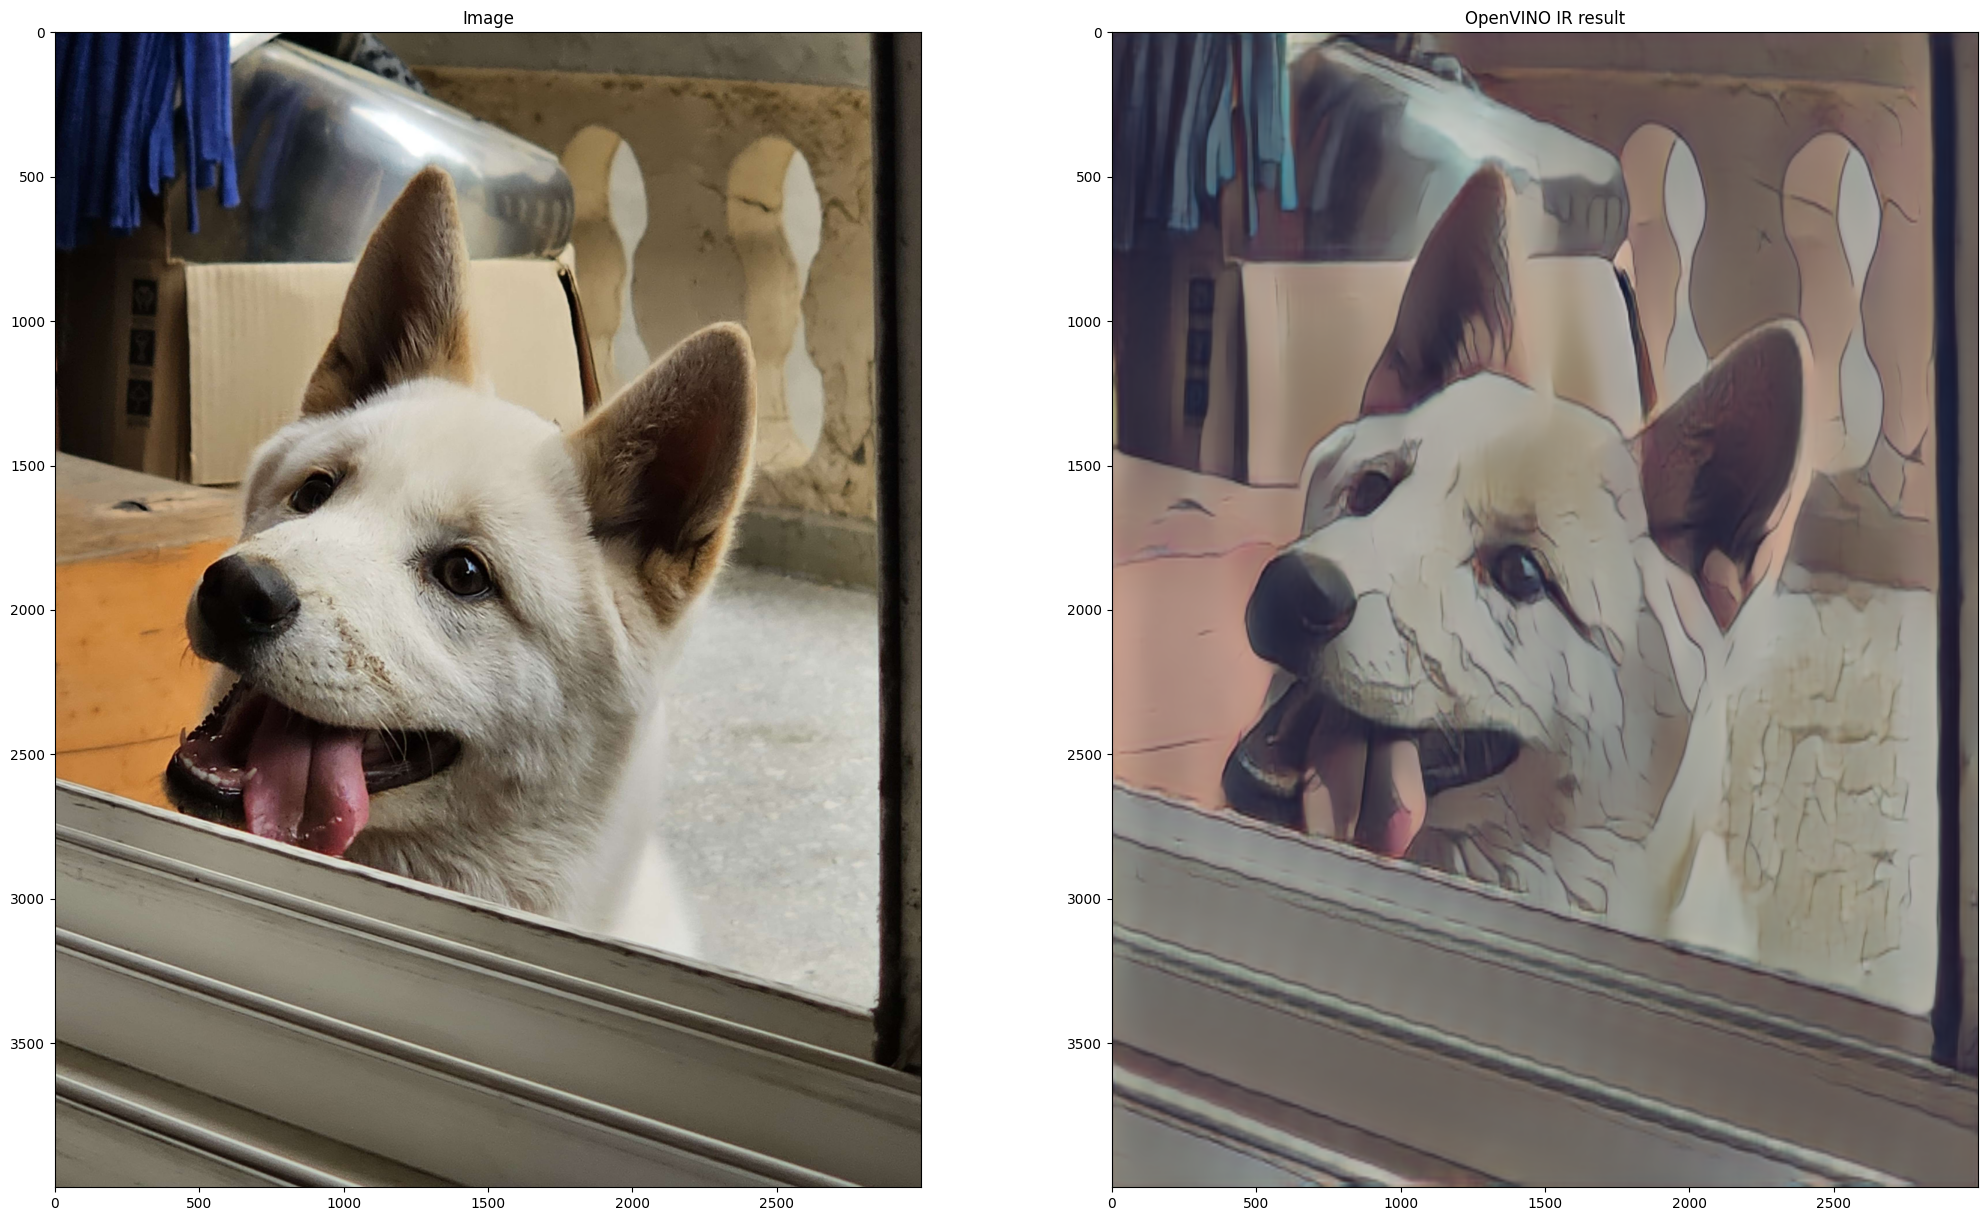

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(25, 15))
ax[0].imshow(image)
ax[1].imshow(result_image_ir)
ax[0].set_title("Image")
ax[1].set_title("OpenVINO IR result");

## Performance Comparison
[back to top ⬆️](#Table-of-contents:)

Measure the time it takes to do inference on an image. This gives an indication of performance. It is not a perfect measure. Since the PaddleGAN model requires quite a bit of memory for inference, only measure inference on one image. For more accurate benchmarking, use [Benchmark Tool](../model-tools/model-tools.ipynb).

In [26]:
NUM_IMAGES = 1
start = time.perf_counter()
for _ in range(NUM_IMAGES):
    compiled_model([input_image])
end = time.perf_counter()
time_ir = end - start
print(f"OpenVINO IR model in OpenVINO Runtime/CPU: {time_ir/NUM_IMAGES:.3f} " f"seconds per image, FPS: {NUM_IMAGES/time_ir:.2f}")

## `PADDLEGAN_INFERENCE` is defined in the "Inference on PaddleGAN model" section above.
## Uncomment the next line to enable a performance comparison with the PaddleGAN model
## if you disabled it earlier.

# PADDLEGAN_INFERENCE = True

if PADDLEGAN_INFERENCE:
    with paddle.no_grad():
        start = time.perf_counter()
        for _ in range(NUM_IMAGES):
            predictor.generator(input_tensor)
        end = time.perf_counter()
        time_paddle = end - start
    print(f"PaddleGAN model on CPU: {time_paddle/NUM_IMAGES:.3f} seconds per image, " f"FPS: {NUM_IMAGES/time_paddle:.2f}")

OpenVINO IR model in OpenVINO Runtime/CPU: 0.528 seconds per image, FPS: 1.89
PaddleGAN model on CPU: 5.084 seconds per image, FPS: 0.20


## References
[back to top ⬆️](#Table-of-contents:)

* [PaddleGAN](https://github.com/PaddlePaddle/PaddleGAN)
* [Paddle2ONNX](https://github.com/PaddlePaddle/paddle2onnx)
* [OpenVINO ONNX support](https://docs.openvino.ai/2021.4/openvino_docs_IE_DG_ONNX_Support.html)
* [Model Conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html)

The PaddleGAN code that is shown in this notebook is written by PaddlePaddle Authors and licensed under the Apache 2.0 license. 
The license for this code is displayed below.

    #  Copyright (c) 2020 PaddlePaddle Authors. All Rights Reserve.
    #
    #Licensed under the Apache License, Version 2.0 (the "License");
    #you may not use this file except in compliance with the License.
    #You may obtain a copy of the License at
    #
    #    http://www.apache.org/licenses/LICENSE-2.0
    #
    #Unless required by applicable law or agreed to in writing, software
    #distributed under the License is distributed on an "AS IS" BASIS,
    #WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    #See the License for the specific language governing permissions and
    #limitations under the License.